# Refactorisation

In [1]:
import numpy as np
import random
import time
from datetime import datetime
from datetime import timedelta
import pandas as pd
from statistics import mean
from loguru import logger
import uuid
import json
import pytz
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from statsmodels.formula.api import ols
plt.style.use('seaborn')

### Read Data

In [2]:
# global constants
filename = '20200715-E7S2WK4HFP-br.jsonl'

def parse_file(n_lines=None):
    with open(filename) as infile:
        if n_lines is not None: # only read at most n_lines
            file_iterator = itertools.islice(infile,n_lines,n_lines+500000)
        else:
            file_iterator = infile
        all_dict = list(map(json.loads,file_iterator))
        logger.info("Loaded {} rows",len(all_dict))
        return all_dict
    
def create_frame(br_object):
    deals = br_object['Bidrequest']['imp'][0]['pmp']['deals']
    for deal in deals:
        if deal['id'] == "E7S2WK4HFP":
            price = deal['bidfloor'] 
    ts = br_object['Timestamp_status_receive_ms']/1000
    tz = pytz.timezone(br_object['Timezone'])
    record={
        'UTC_date': datetime.utcfromtimestamp(ts),
        'local_date': datetime.fromtimestamp(ts,tz=tz),
        'local_hour': datetime.fromtimestamp(ts,tz=tz).hour,
        'ts': ts,
        'TZ': br_object['Timezone'],
        'imps': br_object['Imps'],
        'CPM': price
        }
    record['price'] = (record['imps'] * record['CPM']) / 1000
    return record

In [3]:
%%time

# We have to load 6 000 000 lines
first = True
N_LINES = 0
while N_LINES < 5500000:
    if first:
        first = False
        all_dicts = parse_file(n_lines=N_LINES)
        records = list(map(create_frame, all_dicts))
        df = pd.DataFrame.from_records(records).sort_values("ts",ascending=True)
    else:
        N_LINES += 500000
        all_dicts = parse_file(n_lines=N_LINES)
        records = list(map(create_frame, all_dicts))
        df = df.append(pd.DataFrame.from_records(records).sort_values("ts",ascending=True))  

2020-08-03 15:41:54.822 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-08-03 15:42:23.129 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-08-03 15:42:50.693 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-08-03 15:43:18.649 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-08-03 15:43:58.201 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-08-03 15:45:07.092 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-08-03 15:46:21.539 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-08-03 15:47:50.769 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-08-03 15:50:01.834 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-08-03 15:52:23.095 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-08-03 15:55:14.471 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-08-03 15:58:09.571 | INFO     | __main__:parse_file:11 - Loaded 500000 rows


CPU times: user 4min 56s, sys: 26.9 s, total: 5min 23s
Wall time: 16min 43s


In [13]:
def win_proba(probability):
    return random.random() < probability
def delay_notif():
    if random.random() < 0.90:
        delay = random.randint(2,60)
    else:
        delay = random.randint(60,900)
    return delay

In [14]:
df['win'] = df.apply(lambda x: win_proba(0.95), axis = 1)
df['seconds_notif'] = df.apply(lambda x: delay_notif(), axis = 1)

In [4]:
df = pd.read_pickle('br_clean.pkl')

In [5]:
data = df[df.TZ == 'America/New_York']
data.set_index('local_date', inplace=True)
data.sort_index(inplace = True)

In [6]:
data.head()

,UTC_date,local_hour,ts,TZ,imps,CPM,price,win,seconds_notif
local_date,,,,,,,,,
2020-07-07 20:00:00.042000-04:00,2020-07-08 00:00:00.042,20,1.594166e+09,America/New_York,25.037222,9,0.225335,True,4
2020-07-07 20:00:00.070000-04:00,2020-07-08 00:00:00.070,20,1.594166e+09,America/New_York,27.289524,9,0.245606,True,32
2020-07-07 20:00:01.305000-04:00,2020-07-08 00:00:01.305,20,1.594166e+09,America/New_York,20.371296,9,0.183342,True,38
2020-07-07 20:00:01.706000-04:00,2020-07-08 00:00:01.706,20,1.594166e+09,America/New_York,1.015774,9,0.009142,True,14
2020-07-07 20:00:01.729000-04:00,2020-07-08 00:00:01.729,20,1.594166e+09,America/New_York,2.353671,9,0.021183,True,16


### Pacing

In [71]:
databis = data['2020-07-07 23:58:00':'2020-07-10 23:59:59']

In [8]:
def gen_prop_lr(br_object):
    aggr = br_object.imps.groupby([br_object.index.date, br_object.index.weekday, br_object.index.hour]).sum()
    aggr.index.names = ['date', 'weekday', 'hour']
    aggr = aggr.reset_index()
    model = ols('imps ~ C(weekday) + C(hour)', data=aggr).fit()
    weekday_list = range(7)
    weekday_list = list(itertools.chain.from_iterable(itertools.repeat(x, 24) for x in weekday_list))
    hour_list = list()
    for i in range(7):
        for z in range(24):
            hour_list.append(z)
    df_fitting = pd.DataFrame({'weekday': weekday_list, 'hour': hour_list})
    prediction = model.predict(df_fitting)
    df_fitting['fitted'] = prediction
    pattern = df_fitting.pivot_table('fitted', index=df_fitting.hour, columns=df_fitting.weekday)
    line, col = pattern.shape
    for i in range(col):
        pattern.iloc[:, i] = pattern.iloc[:, i] * 100 / pattern.iloc[:, i].sum()
    return pattern

In [9]:
def gen_prop_lr_hour(br_object):
    aggr = br_object.imps.groupby([br_object.index.date, br_object.index.hour]).sum().reset_index()
    aggr.columns = ['date', 'hour', 'imps']
    model = ols('imps ~ C(hour)', data=aggr).fit()
    hour_list = list()
    for z in range(24):
        hour_list.append(z)
    df_fitting = pd.DataFrame({'hour': hour_list})
    prediction = model.predict(df_fitting)
    df_fitting['fitted'] = prediction
    df_fitting.index = df_fitting.hour
    del df_fitting['hour']
    df_fitting.iloc[:, 0] = df_fitting.iloc[:, 0] * 100 / df_fitting.iloc[:, 0].sum()
    return df_fitting

In [10]:
def meta_prop(data):
    """ Give the proportion of impressions per hour. The output type depends on the input.

    :param data: a dataframe with a datetime as index
    :return: an  integer, a Serie or a Dataframe
    """
    if data.empty:
        unif = True
        without_weekday = True
        prop = 1/24
    elif set(data.index.hour.unique()) != set(range(24)):
        unif = True
        without_weekday = True
        prop = 1/24
    else:
        if set(data.index.weekday.unique()) != set(range(7)):
            unif = False
            without_weekday = True
            prop = gen_prop_lr_hour(data)
        else:
            unif = False
            without_weekday = False
            prop = gen_prop_lr(data)
    return prop, unif, without_weekday

In [11]:
def send_pending_notifications(instance_obj, pending_notif, current_ts=None):
    """ Send notifications

    :param instance_obj: instance of the algorithm class
    :param pending_notif: list of notifications
    :param current_ts: if None: will send all notifications, else send before current_ts
    """
    while len(pending_notif) > 0 and (pending_notif[0]['timestamp'] <= current_ts if current_ts else True):
        ev = pending_notif.pop(0)
        instance_obj.receive_notification(ev['status'], ev['br_price'])

In [69]:
class Pacing:
    """ The pacing algorithm class
    """
    def __init__(self, total_budget, start_date, end_date, timezone):
        """Class constructor"""
        # Raise errors in parameters
        if total_budget < 0:
            raise ValueError("Budget cannot be negative!")
        if start_date > end_date:
            raise ValueError("Start date cannot be later than end date!")

        # Fixed attributes
        self.tz = pytz.timezone(timezone)
        self.start_date = self.tz.localize(start_date)
        self.end_date = self.tz.localize(end_date)
        self.total_days = (self.end_date - self.start_date).days + 1
        self.fix_daily_budget = total_budget / self.total_days
        self.building = list()
        # Impossible day and hour to initialize the setup
        self.day = 0
        self.surplus_day = 0
        self.remaining_budget = 0
        self.engaged_budget = 0
        self.cumspent = 0

    def day_reset(self, ts):
        """ Reset variables when there is a new day
        """
        day = ts.day
        month = ts.month
        year = ts.year
        remaining_days = (self.end_date - ts).days + 2  # +2 because biased calculation of days
        self.surplus_day += self.remaining_budget / remaining_days
        if not self.building:
            self.building_data = pd.DataFrame.from_records(self.building)
        else:
            self.building_data = pd.DataFrame.from_records(self.building, index='Date')
        self.current_hour = -1
        self.remaining_budget_hour = 0
        self.daily_budget = self.fix_daily_budget + self.surplus_day
        self.remaining_budget = self.daily_budget
        self.spent_budget = 0
        self.surplus_hour = 0
        self.BT = [0]
        self.acceleration = [{'ts': self.tz.localize(datetime(year, month, day, 0, 0, 0)),
                              'A': 0}]
        self.speed = [{'ts': self.tz.localize(datetime(year, month, day, 0, 0, 0)),
                       'S': 0}]
        self.size_acceleration = 1
        self.sum_acceleration = 0
        self.size_speed = 1
        self.sum_speed = 0
        self.prop_table, self.unif, self.without_weekday = meta_prop(self.building_data)

    def hour_reset(self, weekday):
        """ Reset budget for the following hour
        """
        self.current_hour += 1
        self.remaining_hours = 24 - self.current_hour
        # Evolutive target
        self.surplus_hour += self.remaining_budget_hour / self.remaining_hours
        if self.unif:
            self.budget_hour = self.prop_table * self.daily_budget + self.surplus_hour
        elif self.without_weekday and not self.unif:
            self.budget_hour = (self.prop_table.iloc[
                                    self.current_hour, 0] / 100) * self.daily_budget + self.surplus_hour
        else:
            self.budget_hour = (self.prop_table.iloc[
                                    self.current_hour, weekday] / 100) * self.daily_budget + self.surplus_hour
        self.target = self.budget_hour / 3600
        self.spent_hour = 0
        self.remaining_budget_hour = self.budget_hour - self.spent_hour

    def gen_mean(self, mean_type):
        """ Return the average variation and speed of variation for bt
        """
        created_time = self.acceleration[-1]['ts'] - timedelta(minutes=30)
        if mean_type == 'acceleration':
            while self.acceleration[0]['ts'] < created_time:
                self.size_acceleration -= 1
                self.sum_acceleration += self.acceleration[0]['A']
                del self.acceleration[0]
            try:
                average = self.sum_acceleration / self.size_acceleration
            except ZeroDivisionError:
                average = 0
        else:
            while self.speed[0]['ts'] < created_time:
                self.size_speed -= 1
                self.sum_speed += self.speed[0]['S']
                del self.speed[0]
            try:
                average = self.sum_speed / self.size_speed
            except ZeroDivisionError:
                average = 0
        return average

    def build_data_prop(self, ts, imps):
        self.building.append({'Date': ts, 'imps': imps})

    def bt_calculation(self, average_acceleration, average_speed, remaining_time, coef=1):
        """ Return the per second budget
        """
        self.remaining_budget = self.daily_budget - (self.engaged_budget + self.spent_budget)
        alpha = average_acceleration * coef
        try:
            bt = self.remaining_budget_hour * ((1 + alpha * average_speed) / remaining_time)
        except ZeroDivisionError:
            bt = 1
        return bt

    def buying_decision(self, ts, price, imps):
        """From a BR, decide whether to buy or not

        :param ts: timestamp of the BR
        :param price: price of the BR
        :param imps: number of impressions
        :return: Boolean
        """

        # Check problem in br
        if price < 0:
            return False
        if imps < 0:
            return False

        # TS de la BR
        weekday = ts.weekday()
        day = ts.day
        month = ts.month
        year = ts.year
        hour = ts.hour

        # If we begin a new day, we reset variables
        if self.day != day:
            self.day_reset(ts)
        self.day = day

        # Changement of hour
        while hour != self.current_hour:
            self.hour_reset(weekday)

        # Build data for proportion lr
        self.build_data_prop(ts, imps)

        # Remaining time before the end of the hour
        end_hour = self.tz.localize(datetime(year, month, day, hour, 59, 59, 999999))
        remaining_time = datetime.timestamp(end_hour) - datetime.timestamp(ts)

        # Calculation of bt
        average_acceleration = self.gen_mean('acceleration')
        average_speed = self.gen_mean('speed')
        bt = self.bt_calculation(average_acceleration, average_speed, remaining_time)

        # Calculation of vt and at
        self.BT.append(bt)
        vt = self.BT[-1] - self.BT[-2]
        self.speed.append({'ts': ts,
                           'S': vt})
        at = self.speed[-1]['S'] - self.speed[-2]['S']
        self.acceleration.append({'ts': ts,
                                  'A': at})

        # Buying decision
        if (bt >= self.target) and (self.remaining_budget - price) >= 0:
            buying = True
            self.engaged_budget += price
            self.spent_hour += price
        else:
            buying = False
        self.remaining_budget_hour = self.budget_hour - self.spent_hour

        return buying

    def receive_notification(self, status, br_price):
        """ From a notification, take into account the status (win/lose)
        """
        if status == 'win':
            self.engaged_budget -= br_price
            self.spent_budget += br_price
            self.cumspent += br_price
        elif status == 'lose':
            self.engaged_budget -= br_price
            self.spent_hour -= br_price

In [73]:
def main(data):
    logger.info(f"Start pacing on {len(data)} bid requests")
    pacing = Pacing(total_budget=88000, start_date=datetime(2020, 7, 7), end_date=datetime(2020, 7, 10),
                    timezone='America/New_York')
    records = list()
    pending_notifications = list()
    day = pacing.start_date.day
    for current_ts, row in data.iterrows():
        # End of the campaign ?
        if current_ts > pacing.end_date + timedelta(days=1):
            break
        # Send current notifications
        send_pending_notifications(pacing, pending_notifications, current_ts)
        if current_ts.day != day:
            day = current_ts.day
            # Send remaining notifications
            send_pending_notifications(pacing, pending_notifications)
            records[-1]['engaged'] = pacing.engaged_budget
            pacing.remaining_budget = pacing.daily_budget - (pacing.engaged_budget + pacing.spent_budget)
            records[-1]['remaining'] = pacing.remaining_budget
            records[-1]['spent'] = pacing.spent_budget
            records[-1]['cumspent'] = pacing.cumspent

        # Receive BR
        buying = pacing.buying_decision(current_ts, row['price'], row['imps'])

        # Making a decision
        if buying:
            next_notif_ts = current_ts + timedelta(seconds=row['seconds_notif'])
            status = "win" if row['win'] else "lose"
            notif_id = uuid.uuid4()
            pending_notifications.append(
                {"timestamp": next_notif_ts, "status": status, 'br_price': row['price'], 'id': notif_id})
            pending_notifications.sort(key=lambda x: x['timestamp'])
        record = {
            'buying': buying,
            'remaining': pacing.remaining_budget,
            'spent': pacing.spent_budget,
            'cumspent': pacing.cumspent,
            'engaged': pacing.engaged_budget
        }
        records.append(record)

    # Send remaining notifications
    send_pending_notifications(pacing, pending_notifications)

    # Update last row after sending last notifications
    records[-1]['engaged'] = pacing.engaged_budget
    pacing.remaining_budget = pacing.daily_budget - (pacing.engaged_budget + pacing.spent_budget)
    records[-1]['remaining'] = pacing.remaining_budget
    records[-1]['spent'] = pacing.spent_budget
    records[-1]['cumspent'] = pacing.cumspent
    pacing_df = pd.DataFrame.from_records(records)
    new_df = pd.concat([data.reset_index(), pacing_df], axis=1, ignore_index=True)
    new_df.columns = ['local_date', 'UTC_date', 'hour', 'ts', 'TZ', 'imps', 'CPM', 'price', 'win', 'seconds_notif',
                      'buying', 'remaining', 'spent', 'cumspent', 'engaged']
    new_df.set_index('local_date', inplace=True)
    if len(new_df) == len(data):
        logger.info(f"Successful pacing")
    else:
        logger.info(f"Failed pacing")
    return new_df

In [74]:
%%time
pacing_results = main(databis)

2020-08-05 15:23:52.734 | INFO     | __main__:main:2 - Start pacing on 1028665 bid requests
2020-08-05 15:29:37.226 | INFO     | __main__:main:59 - Successful pacing


CPU times: user 5min 40s, sys: 4.35 s, total: 5min 45s
Wall time: 5min 45s


In [75]:
pacing_results.groupby(pacing_results.index.day).tail(1)

,UTC_date,hour,ts,TZ,imps,CPM,price,win,seconds_notif,buying,remaining,spent,cumspent,engaged
local_date,,,,,,,,,,,,,,
2020-07-07 23:59:59.803000-04:00,2020-07-08 03:59:59.803,23,1.594181e+09,America/New_York,8.834286,9,0.079509,True,52,True,21961.990444,38.009556,38.009556,-6.383782e-15
2020-07-08 23:59:59.259000-04:00,2020-07-09 03:59:59.259,23,1.594267e+09,America/New_York,30.677381,9,0.276096,True,24,True,20.050287,29300.613194,29338.622750,2.281508e-14
2020-07-09 23:59:59.139000-04:00,2020-07-10 03:59:59.139,23,1.594354e+09,America/New_York,4.214881,9,0.037934,True,5,True,3.561410,29327.127215,58665.749966,-2.131975e-13
2020-07-10 23:59:59.866000-04:00,2020-07-11 03:59:59.866,23,1.594440e+09,America/New_York,36.899762,9,0.332098,True,53,True,2.216678,29332.033357,87997.783323,-6.398094e-13


In [81]:
pacing_results.cumspent.tail(1).iloc[0]

87997.78332254807

In [82]:
sum(pacing_results.buying)*100/len(pacing_results)

99.28907856299183

In [76]:
day = pacing_results['2020-07-10']

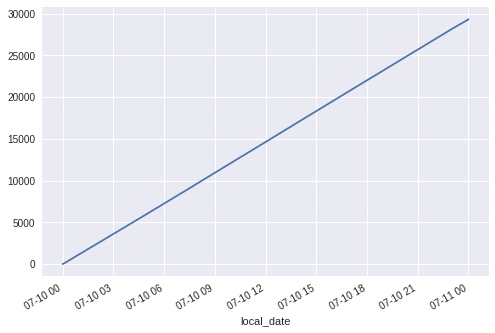

In [77]:
day.spent.plot()

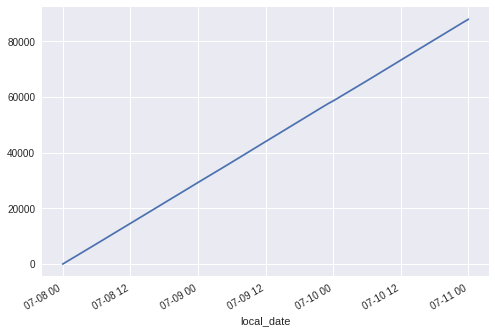

In [78]:
pacing_results.cumspent.plot()